In [1]:
# load dataset
#dataset = pd.read_csv('athrav_sawer_ann_predictions.csv')

In [2]:
# drop columns we don't want to predict
#dataset.drop(['Market Name','Commodity', 'Variety','Variety','Grade','Min Price (Rs./Quintal)','Max Price (Rs./Quintal)'], axis = 1,inplace=True)


In [3]:
#dataset['Date']=pd.to_datetime(dataset['Date'])

In [4]:
#dataset.Date=dataset.Date.astype(str)

In [5]:
#dataset.to_csv(r'/home/akash/soyabean/sawerdata/athrav_sawer_ann_predictions.csv')

In [6]:
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
import pandas as pd

Using TensorFlow backend.
/home/akash/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/akash/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/akash/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/akash/.local/lib/python3.6/site-packages/tensorflow/python/fra

In [7]:
dataset = pd.read_csv('athrav_sawer_ann_predictions.csv')

In [8]:
dataset.Date=dataset.Date.astype(str)

In [9]:
dataset['Date']

0      2017-01-04
1      2017-01-06
2      2017-01-07
3      2017-01-09
4      2017-01-10
          ...    
591    2019-12-02
592    2019-12-03
593    2019-12-04
594    2019-12-05
595    2019-12-07
Name: Date, Length: 596, dtype: object

In [10]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df



In [11]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)



In [12]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]



In [13]:
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled



In [14]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]



In [15]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model



In [16]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


In [17]:
series = read_csv('athrav_sawer_ann_predictions.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
 

In [18]:
series.head()

Date
2017-01-04    2951.2695
2017-01-06    2948.2778
2017-01-07    2948.1184
2017-01-09    2888.8237
2017-01-10    2879.4023
Name: Modal Price (Rs./Quintal), dtype: float64

In [19]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 

 

In [20]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 


In [21]:
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
 


In [22]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 


In [23]:
# fit the model
lstm_model = fit_lstm(train_scaled,1,300,4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

W1226 18:17:08.854282 139918096959296 deprecation_wrapper.py:119] From /home/akash/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



array([[-0.02577826],
       [-0.04493104],
       [-0.05478673],
       [-0.04002546],
       [-0.04941746],
       [-0.11120241],
       [-0.03157615],
       [-0.05357311],
       [-0.07117208],
       [-0.07209484],
       [-0.06603114],
       [-0.05997396],
       [-0.06213714],
       [-0.04573628],
       [-0.0562755 ],
       [-0.08673926],
       [-0.04265372],
       [-0.05139189],
       [-0.04834881],
       [-0.0755559 ],
       [-0.07834335],
       [-0.07450469],
       [-0.06073613],
       [-0.0551728 ],
       [-0.06425696],
       [-0.0723663 ],
       [-0.04182532],
       [-0.04910183],
       [-0.08187225],
       [-0.04443471],
       [-0.05006742],
       [-0.06028129],
       [-0.05690736],
       [-0.05414121],
       [-0.06490927],
       [-0.04492565],
       [-0.07467718],
       [-0.07093776],
       [-0.08677272],
       [-0.06980091],
       [-0.06099074],
       [-0.07606269],
       [-0.05910035],
       [-0.06237809],
       [-0.04374959],
       [-0

In [24]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))



Month=1, Predicted=3789.412546, Expected=3825.631300
Month=2, Predicted=3811.803964, Expected=3839.473900
Month=3, Predicted=3826.681898, Expected=3768.873000
Month=4, Predicted=3798.889903, Expected=3802.251000
Month=5, Predicted=3803.929117, Expected=3741.327400
Month=6, Predicted=3773.252694, Expected=3751.369000
Month=7, Predicted=3764.971996, Expected=3826.952600
Month=8, Predicted=3802.625749, Expected=3838.361600
Month=9, Predicted=3821.178687, Expected=3778.760700
Month=10, Predicted=3801.365913, Expected=3800.022500
Month=11, Predicted=3803.869358, Expected=3889.451200
Month=12, Predicted=3854.175258, Expected=3838.835400


In [25]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 45.007


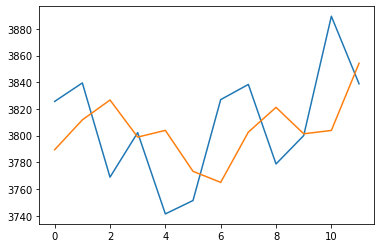

In [26]:
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()